In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Input
import warnings
# from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
file_path="data2/고용형태별조사DB_09-02_15-31.csv"
df=pd.read_csv(file_path, encoding="cp949")

#데이터 전처리 추가
df=df.drop(columns="Unnamed: 0")
df['임금총액']=df['정액급여액']+df['초과급여액']+df['상여금성과급총액']/12 #임금총액
df['임금총액']=df['임금총액'].astype(int)
df=df.drop(columns=['정액급여액','초과급여액','상여금성과급총액'])
df['총근로시간']=df['소정실근로시간수']+df['초과실근로시간수']+df['휴일실근로시간수'] #노동시간합계
df=df.drop(['소정실근로시간수','초과실근로시간수','휴일실근로시간수'], axis=1)
df=df.drop(columns=['소정실근로일수','휴일실근로일수']) #필요없는 칼럼
df=df.drop(columns=['입사연도','입사월'], axis=1) #필요없는 칼럼

In [3]:
#가중치 분리
w = df['가중값']
df=df.drop(columns='가중값', axis=1)

#수치 데이터를 범주 데이터로 변환
col_code_kewords=['여부','코드']
all_col = df.columns.tolist()
boundary_list={}

q_wage= 5 #임금총액의 분위수 
q_features=10 #나머지 범주들의 분류 갯수

for col in all_col:
    if not any(keyword in col for keyword in col_code_kewords):
        
        if "액" in col:
            col_name_decile= f"{col}_{q_wage}분위"
            df[col_name_decile], bin_edges = pd.qcut(df[col], q=q_wage, duplicates='drop',labels=range(0,q_wage), retbins=True)
        else:
            col_name_decile= f"{col}_{q_features}분위"
            df[col_name_decile], bin_edges = pd.qcut(df[col], q=q_features, duplicates='drop',labels=False, retbins=True)
        boundary_list[col]=bin_edges.tolist()
        df=df.drop(columns=col, axis=1)
        df[col_name_decile]=df[col_name_decile].astype(int)


In [4]:
#XGBoost 전처리
target_col= f"임금총액_{q_wage}분위"
y= df[target_col]
df=df.drop(columns=target_col, axis=1)
x=df
x_t, x_10, y_t, y_10, w_t, w_10 = train_test_split(x,y,w, test_size=0.1, random_state=36)
del df


In [6]:
#XGboost

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
model= xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=q_wage, 
    eval_metric='mlogloss', 
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=8,
    verbosity=0)

model.fit(x_t, y_t, sample_weight=w_t)
y_pred = model.predict(x_10)


In [7]:
#정확도 및 모델 품질 측정

accuracy = accuracy_score(y_10, y_pred, sample_weight=w_10)
print(f"\n정확도: {accuracy:.4f}")
print("\n### 혼동 행렬 ###")
print(confusion_matrix(y_10, y_pred))

print("\n### 분류 리포트 ###")
print(classification_report(y_10, y_pred))


정확도: 0.6357

### 혼동 행렬 ###
[[30580  6723   920   362   127]
 [ 5005 24456  7419  1722   521]
 [  944  8700 19413  8292  1834]
 [  310  1823  7684 20122  8811]
 [   99   422  1301  6817 30366]]

### 분류 리포트 ###
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     38712
           1       0.58      0.63      0.60     39123
           2       0.53      0.50      0.51     39183
           3       0.54      0.52      0.53     38750
           4       0.73      0.78      0.75     39005

    accuracy                           0.64    194773
   macro avg       0.64      0.64      0.64    194773
weighted avg       0.64      0.64      0.64    194773



In [9]:
plt.rc('font', family='NanumGothic')

In [10]:
#변수 영향력 분석_ 샤프 분석

x_shap = x_10.sample(n=1000, random_state=12)
explainer =shap.TreeExplainer(model)
shap_value = explainer(x_shap)


In [ ]:
#샤프 값 후처리

df_shap=pd.DataFrame(columns=shap_value.feature_names)
f_num =len(x_shap.columns)
shap_mean_value=np.empty((q_wage,f_num))
for i in range(q_wage):
    for j in range(f_num):
        shap_mean_value[i][j] = np.abs(shap_value.values[:,j,i]).mean()

index_list=[]
for i in range(q_wage):
    index_name=f"임금{i+1}분위"
    index_list.append(index_name)

df_shap=pd.DataFrame(shap_mean_value, index=index_list, columns=shap_value.feature_names)
print (df_shap)

In [ ]:
# 애니메이션 막대 전처리
df_shap.index.name = '임금분위'

df_reset= df_shap.reset_index()
df_pivot =df_reset.melt(
    id_vars='임금분위',
    var_name='항목',
    value_name='영향력'
)

df_pivot['순위']=df_pivot.groupby('임금분위')['영향력'].rank(method="first", ascending=False)
df_sorted= df_pivot.sort_values(by=['임금분위','항목'], ascending=[True, False])
df_sorted['순위']=df_sorted['순위'].astype(str)
fixed_order = sorted(df_sorted['항목'].unique())

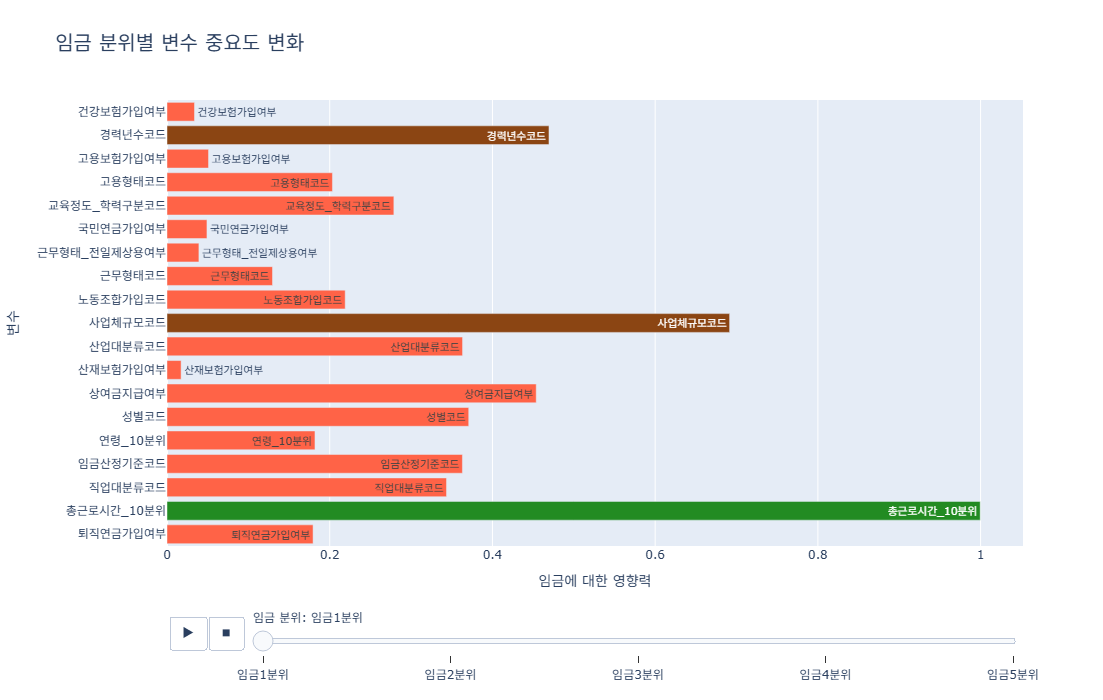

In [163]:
#애니메이션 막대 그리기

import plotly.express as px
#import plotly.graph_objects as go

colormap={}
colormap['1']='forestgreen'
colormap['2']='saddlebrown'
colormap['3']='saddlebrown'
for i in range(len(df_sorted['순위'].unique())-3):
    str_num=f"{i+4}"
    colormap[str_num]="tomato"

fig=px.bar(
    df_sorted,
    x='영향력',
    y='항목',
    animation_frame='임금분위',
    orientation='h',         # 가로 막대 그래프
    title='임금 분위별 변수 중요도 변화',
    labels={'영향력': '임금에 대한 영향력', '항목': '변수'},
    text='항목',
    color='순위', # 색상의 기준을 '순위' 열로 지정
    color_discrete_map=colormap,
    category_orders={'항목':fixed_order},
    
)

fig.update_layout(
    height=700,
    title_font_size=20,
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    # 애니메이션 버튼 및 슬라이더 텍스트 설정
    sliders=[dict(currentvalue={'prefix': '임금 분위: '})],
    updatemenus=[dict(buttons=[dict(args=[None, {"frame": {"duration": 1500}}])])] # 재생 속도 조절
)
fig.update_layout(coloraxis_showscale=False,
                 showlegend=False)

fig.show()
fig.write_html("고용형태별.html")